## Test

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Qwen2ForCausalLM
from utils.skip_layer import *

path = "E:\pretrained_models\Qwen\Qwen2___5-0___5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(
    path, device_map="auto", torch_dtype="auto")


d:\app\anaconda\envs\webui\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\app\anaconda\envs\webui\lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


<class 'transformers.models.qwen2.tokenization_qwen2_fast.Qwen2TokenizerFast'>


In [2]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [21]:
model.config.num_hidden_layers 

24

### 1. choose_layers

In [3]:
# n = m + num_hidden_layers // 8
choose_layers(model.config, strategy="sl-h") 

[4, 5, 6]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


[DEBUG] Num_Layer
24
[DEBUG] Entropy
[6.279262065887451, 6.590538024902344, 5.376992702484131, 6.856441974639893, 6.385911464691162, 5.9859232902526855, 5.461923122406006, 5.661866664886475, 6.401177883148193, 6.2389960289001465, 6.7234039306640625, 5.950413227081299, 6.896797180175781, 6.602458477020264, 6.014623641967773, 5.732835292816162, 5.753632068634033, 6.114433288574219, 6.958430767059326, 6.123170375823975, 6.181131362915039, 7.453919887542725, 6.359779357910156, 3.1416938304901123]
[DEBUG] Best layer: 20, entropy diff: -0.05796098709106445, max_idx: 21


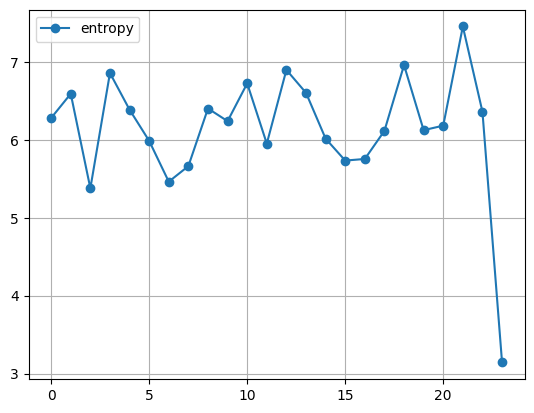

[20, 21, 22]

In [4]:
# n = m + num_hidden_layers // 8
choose_layers(model.config, 
    strategy="sl-d", model=model, 
    debug=True,
    prefix_logits=tokenizer("The capital of France is GGaaaa", return_tensors="pt",
)["input_ids"].to(model.device))

In [5]:
torch.sum(torch.randn([1, 2, 3]))

tensor(2.2095)

### 2 hook

In [5]:
from utils.skip_layer import set_skip_layers
import torch
set_skip_layers(model, list(range(model.config.num_hidden_layers)))




In [6]:
x = tokenizer(["The capital of France is Paris", 
               "The capital of France is Paris"], return_tensors="pt").to(model.device)
info = model(
    **x, output_hidden_states=True
)


In [8]:
info = info.hidden_states

In [9]:
len(info)

25

In [11]:
info[0].shape

torch.Size([2, 6, 896])

In [18]:
import torch
for i in range(1, len(info)):
    print(info[i][1].eq(info[i-1][1]).all())
# Because the last output will be activated, so you see the last False

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')


In [22]:
info[-1][1].eq(info[-2][1])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [8]:
import re
len(re.findall(r"[\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FAF\uFF66-\uFF9F々〆〤、。！？「」『』【】]", "こんにちは、私はAIです。今日は良い天気ですね！"))

22

In [9]:
(1, 2, 3)[2:]

(3,)

In [22]:
a = torch.rand((3, 1, 1))

In [19]:
b = torch.rand((3, 2))

In [21]:
torch.cat([b, a], dim=-1).shape

torch.Size([3, 3])

In [24]:
torch.argmax(a, dim=-1).shape

torch.Size([3, 1])